In [7]:
import pandas as pd
import numpy as np
import os
import time
import copy

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
import survivors.datasets as ds

In [8]:
X, y, features, categ, sch_nan = ds.load_pbc_dataset()

In [9]:
bins = cnt.get_bins(time=y["time"], cens=y["cens"])

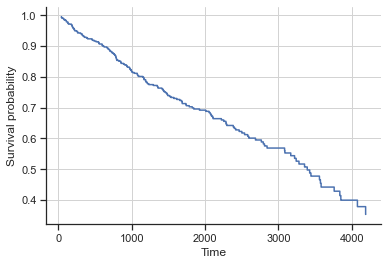

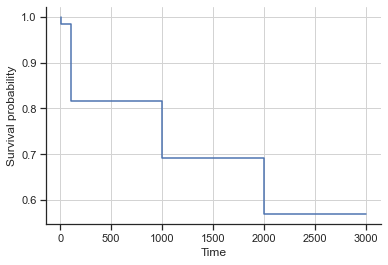

In [90]:
from survivors.tree.stratified_model import KaplanMeier

def plot_surival_function(sf, bins):
    plt.step(bins, sf)
    plt.xlabel('Time')
    plt.ylabel('Survival probability')
    plt.show()

km = KaplanMeier()
km.fit(durations=y["time"], right_censor=y["cens"])
sf_km = km.survival_function_at_times(times=bins)
plot_surival_function(sf_km, bins)

bins_short = [10, 100, 1000, 2000, 3000]
sf_km_short = km.survival_function_at_times(times=bins_short)
plot_surival_function(sf_km_short, bins_short)

In [17]:
from survivors.tree import CRAID

# Создание дерева выживаемости
cr = CRAID(criterion='peto', depth=3, min_samples_leaf=0.1,
           categ=categ, leaf_model="base")

# Обучение дерева
cr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_cr = cr.predict_at_times(X, bins=bins, mode="surv")

# Визуализация структуры дерева
cr.visualize(target="time", mode="surv")

In [30]:
from survivors.ensemble import BootstrapCRAID

# Создание дерева выживаемости
bstr = BootstrapCRAID(n_estimators=10, size_sample=0.7, ens_metric_name='IBS_REMAIN', 
                      max_features=0.3, criterion='peto', depth=10,
                      min_samples_leaf=0.01, categ=categ, leaf_model="base")

# Обучение дерева
bstr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_bstr = bstr.predict_at_times(X, bins=bins, mode="surv")

fitted: 10 models.


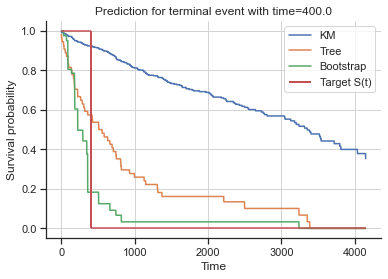

In [68]:
def plot_func_comparison(y_true, y_preds, labels):
    linestyle = ('solid' if y_true["cens"] else 'dashed')
    fig, ax = plt.subplots()
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label=label)
    ax.hlines(1.0, 0, y_true["time"], color='r', linestyle=linestyle)
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color='r', linestyle=linestyle)
    ax.vlines(y_true["time"], 0, 1, color='r', 
              linestyle=linestyle, linewidth=2, label="Target S(t)")
    ax.legend()
    plt.title(f'Prediction for {"terminal" if y_true["cens"] else "censured"} event with time={y_true["time"]}')
    plt.xlabel('Time')
    plt.ylabel('Survival probability')
    plt.show()
    
plot_func_comparison(y[0],
                     [sf_km, sf_cr[0], sf_bstr[0]], 
                     ["KM", "Tree", "Bootstrap"])

In [40]:
metr.ibs.__name__

'ibs'

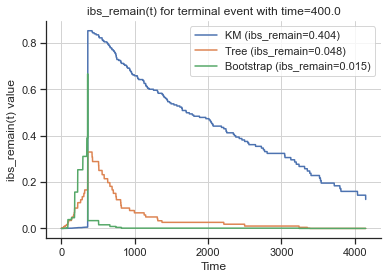

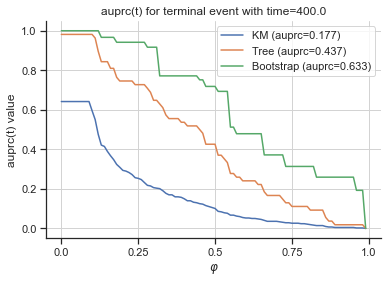

In [82]:
def plot_metric_comparison(y_true, y_preds, labels, bins, metric):
    fig, ax = plt.subplots()
    m_name = metric.__name__
    
    for y_pred, label in zip(y_preds, labels):
        m_by_time = metric(y_true[np.newaxis], y_true[np.newaxis], y_pred[np.newaxis], bins, axis=1)
        m_val = metric(y_true[np.newaxis], y_true[np.newaxis], y_pred[np.newaxis], bins, axis=-1)
        ax.plot(m_by_time, label=f"{label} ({m_name}={m_val:.3f})")
    ax.legend()
    plt.title(f'{m_name}(t) for {"terminal" if y_true["cens"] else "censured"} event with time={y_true["time"]}')
    if m_name.find("auprc") == -1:
        plt.xlabel('Time')
    else:
        plt.xlabel(r'$\varphi$')
        plt.xticks(np.linspace(0, 100, 5), labels=np.linspace(0, 1, 5))
    plt.ylabel(f'{m_name}(t) value')
    plt.show()

plot_metric_comparison(y[0], [sf_km, sf_cr[0], sf_bstr[0]], ["KM", "Tree", "Bootstrap"], bins, metr.ibs_remain)
plot_metric_comparison(y[0], [sf_km, sf_cr[0], sf_bstr[0]], ["KM", "Tree", "Bootstrap"], bins, metr.auprc)

In [65]:
X.iloc[0].round(1).to_dict()

{'trt': 1.0,
 'age': 58.8,
 'sex': 1.0,
 'ascites': 1.0,
 'hepato': 1.0,
 'spiders': 1.0,
 'edema': 1.0,
 'bili': 14.5,
 'chol': 261.0,
 'albumin': 2.6,
 'copper': 156.0,
 'alk': 1718.0,
 'ast': 138.0,
 'trig': 172.0,
 'platelet': 190.0,
 'protime': 12.2,
 'stage': 4.0}